In [4]:
# !unzip '/content/drive/MyDrive/BERT Text Classification/archive (2).zip' -d'/content/drive/MyDrive/BERT Text Classification/'

Archive:  /content/drive/MyDrive/BERT Text Classification/archive (2).zip
  inflating: /content/drive/MyDrive/BERT Text Classification/test.txt  
  inflating: /content/drive/MyDrive/BERT Text Classification/train.txt  
  inflating: /content/drive/MyDrive/BERT Text Classification/val.txt  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.initializers import TruncatedNormal
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.models import Model


import warnings
warnings.filterwarnings('ignore')

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
train = '/content/drive/MyDrive/BERT_Text_Classification/train.txt'
test = '/content/drive/MyDrive/BERT_Text_Classification/test.txt'
val = '/content/drive/MyDrive/BERT_Text_Classification/val.txt'

In [7]:
train_df = pd.read_csv(train, header = None, sep = ';', names = ['Input', 'Sentiment'])
test_df = pd.read_csv(test, header = None, sep = ';', names = ['Input', 'Sentiment'])
val_df = pd.read_csv(val, header = None, sep = ';', names = ['Input', 'Sentiment'])

In [8]:
df = pd.concat([train_df, test_df, val_df], axis = 0)
df.head()

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [9]:
df.shape

(20000, 2)

# Text Preprocessing

In [10]:
def preprocess(df, column):
    '''
    this function will return the df with clean text after preprocessing
    '''

    # lower case
    df[column] = df[column].str.lower()

    return df

In [11]:
df_clean = preprocess(df, 'Input')
df_clean.head()

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [12]:
# creating a column which will have total no of words in a sentence
df_clean['num_words'] = df_clean['Input'].apply(lambda x: len(x.split()))
df_clean.head()

,Input,Sentiment,num_words
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,21
2,im grabbing a minute to post i feel greedy wrong,anger,10
3,i am ever feeling nostalgic about the fireplac...,love,18
4,i am feeling grouchy,anger,4


In [13]:
# checking max len sentence
max(df_clean['num_words'])

66

In [14]:
df_copy = df_clean.copy()

In [15]:
# changing the dtype of the categoty to encode into codes
df_copy['Sentiment'] = df_copy['Sentiment'].astype('category')
# df_copy.head()

In [16]:
df_copy['Sentiment'].cat.codes.unique()

array([4, 0, 3, 5, 1, 2], dtype=int8)

In [17]:
encoded_dict = {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}

In [18]:
df_copy['Sentiment'] = df_copy['Sentiment'].cat.codes
# df_copy['Sentiment']

In [19]:
df_copy.head()

,Input,Sentiment,num_words
0,i didnt feel humiliated,4,4
1,i can go from feeling so hopeless to so damned...,4,21
2,im grabbing a minute to post i feel greedy wrong,0,10
3,i am ever feeling nostalgic about the fireplac...,3,18
4,i am feeling grouchy,0,4


In [20]:
train_df, test_df = train_test_split(df_copy, test_size = 0.2,
                                     random_state = 42, stratify = df_copy['Sentiment'])

In [21]:
train_df.shape, test_df.shape

((16000, 3), (4000, 3))

<Axes: >

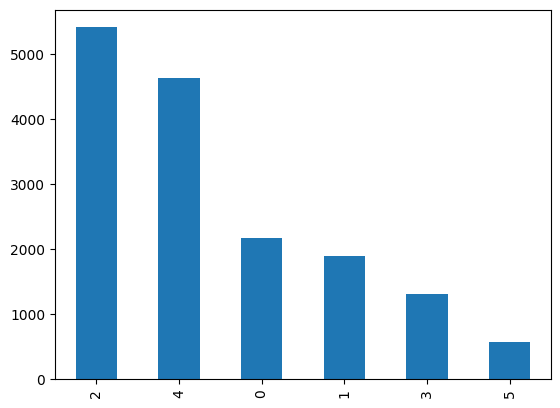

In [22]:
train_df['Sentiment'].value_counts().plot.bar()

In [23]:
to_categorical(train_df['Sentiment'])[:4]

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

# Loading BERT Model

In [24]:
# !pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.8 MB/s eta 0:00:00


In [25]:
from transformers import AutoTokenizer, TFBertModel

# auto-tokenizer will convert the data into bert input form for the specified model
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [26]:
# save the model for deployment
tokenizer.save_pretrained('bet-tokenizer')
bert.save_pretrained('bert-model')

In [27]:
tokenizer('my name is sanket')

{'input_ids': [101, 1139, 1271, 1110, 7095, 2105, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [28]:
# tokenizing entire dataset
x_train = tokenizer(
    text = train_df['Input'].tolist(),
    add_special_tokens = True,
    max_length = 100,
    truncation = True,
    # padding = True,
    pad_to_max_length = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_test = tokenizer(
    text = test_df['Input'].tolist(),
    add_special_tokens = True,
    max_length = 100,
    pad_to_max_length = True,
    truncation = True,
    # padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [31]:
# x_train['input_ids']

<tf.Tensor: shape=(16000, 100), dtype=int32, numpy=
array([[  101,   178,  1821, ...,     0,     0,     0],
       [  101, 13280,  2296, ...,     0,     0,     0],
       [  101,   178,  1145, ...,     0,     0,     0],
       ...,
       [  101, 13280,  1136, ...,     0,     0,     0],
       [  101,   178,  1450, ...,     0,     0,     0],
       [  101, 13280,  2296, ...,     0,     0,     0]], dtype=int32)>

In [32]:
# x_test['input_ids']

<tf.Tensor: shape=(4000, 100), dtype=int32, numpy=
array([[ 101,  178, 1821, ...,    0,    0,    0],
       [ 101,  178, 1202, ...,    0,    0,    0],
       [ 101,  178, 3007, ...,    0,    0,    0],
       ...,
       [ 101,  178, 1821, ...,    0,    0,    0],
       [ 101,  178, 1408, ...,    0,    0,    0],
       [ 101,  178, 1169, ...,    0,    0,    0]], dtype=int32)>

In [29]:
max_len = 100

input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[0]    # 0 is last hidden state. 1 is pooler_output
out = keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation = 'relu')(out)
out = keras.layers.Dropout(0.1)(out)
out = Dense(32, activation = 'relu')(out)

y = Dense(6, activation = 'softmax')(out)

model = Model(inputs = [input_ids, input_mask], outputs = y)

model.layers[2].trainable = True    # bert model layers start from 2nd place so we want to train from 2nd layer

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

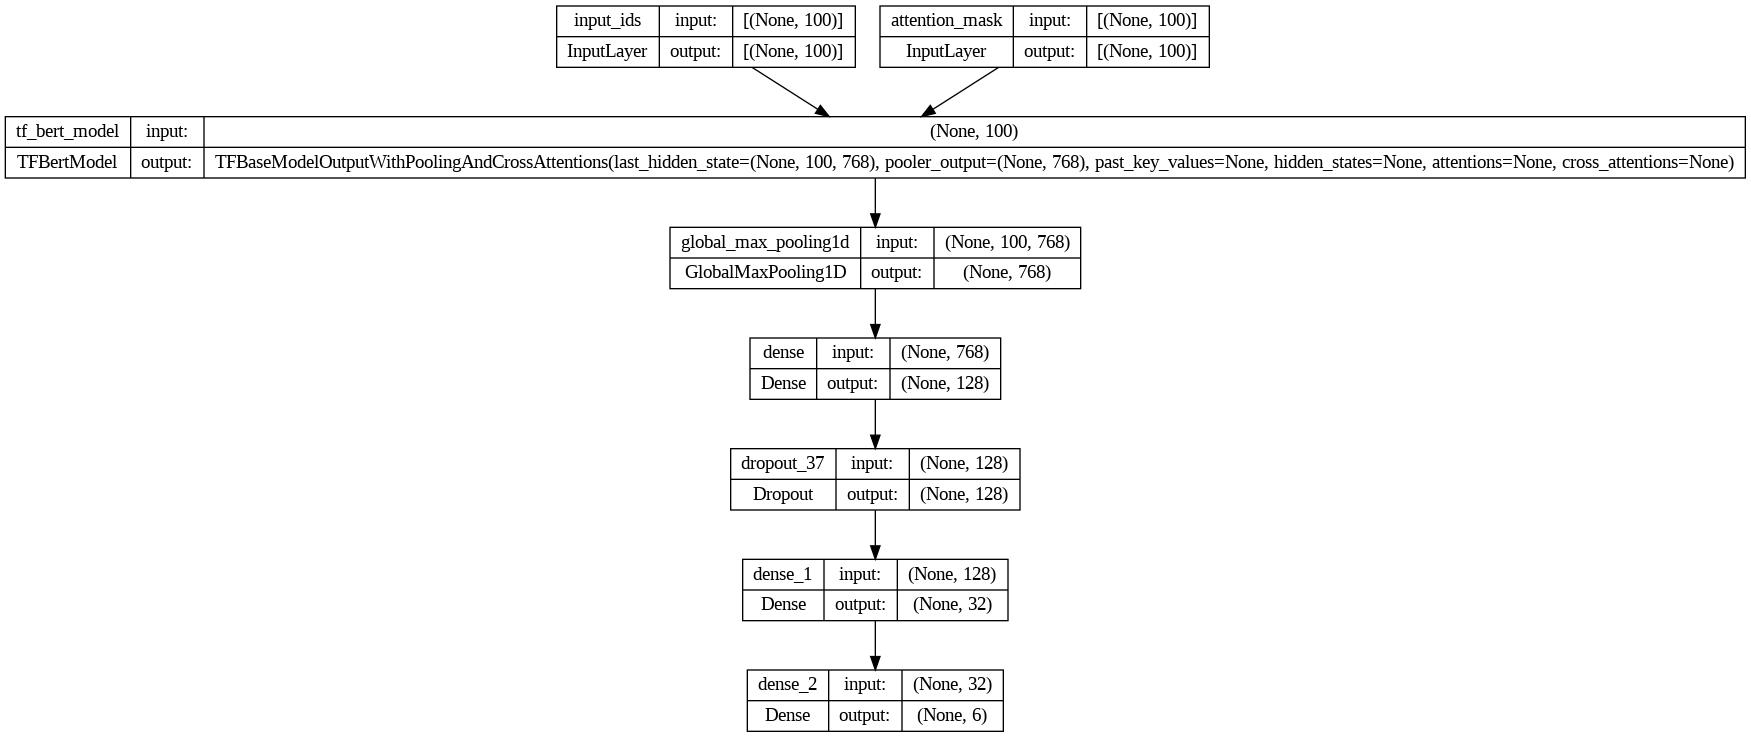

In [31]:
plot_model(model,  show_shapes = True)

In [32]:
optimizer = Adam(
    learning_rate = 5e-05,
    epsilon = 1e-08,
    decay = 0.01,
    clipnorm = 1.0)

# loss and metrics
loss = CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy')

# compiling the model
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = [metric])

In [33]:
train_history = model.fit(
    x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']},
    y = to_categorical(train_df['Sentiment']),

    validation_data = ({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, to_categorical(test_df['Sentiment'])),

    epochs = 1,
    batch_size = 36)

445/445 [==============================] - 374s 785ms/step - loss: 0.5300 - balanced_accuracy: 0.8196 - val_loss: 0.1904 - val_balanced_accuracy: 0.9235


In [34]:
# saving model
model.save_weights('/content/drive/MyDrive/BERT_Text_Classification/text_classification_bert_weights.h5')

# saving model
model.save('/content/drive/MyDrive/BERT Text Classification/text_classification_bert.h5')

# saving tokenizer


In [35]:
bert.save_pretrained('/content/drive/MyDrive/BERT_Text_Classification/bert-model')

In [36]:
tokenizer.save_pretrained('/content/drive/MyDrive/BERT_Text_Classification/tokenizer_directory/')

('/content/drive/MyDrive/BERT_Text_Classification/tokenizer_directory/tokenizer_config.json',
 '/content/drive/MyDrive/BERT_Text_Classification/tokenizer_directory/special_tokens_map.json',
 '/content/drive/MyDrive/BERT_Text_Classification/tokenizer_directory/vocab.txt',
 '/content/drive/MyDrive/BERT_Text_Classification/tokenizer_directory/added_tokens.json',
 '/content/drive/MyDrive/BERT_Text_Classification/tokenizer_directory/tokenizer.json')

In [ ]:
model1 = model.load_weights('/content/drive/MyDrive/BERT Text Classification/text_classification_bert.h5')

In [ ]:
type(model1)

NoneType

In [37]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})
predicted[0]

125/125 [==============================] - 27s 198ms/step


array([9.6857899e-01, 1.2849846e-02, 9.8038977e-03, 1.7155525e-03,
       6.4680586e-03, 5.8366789e-04], dtype=float32)

In [38]:
y_predict = np.argmax(predicted, axis = 1)
y_predict

array([0, 2, 1, ..., 2, 1, 4])

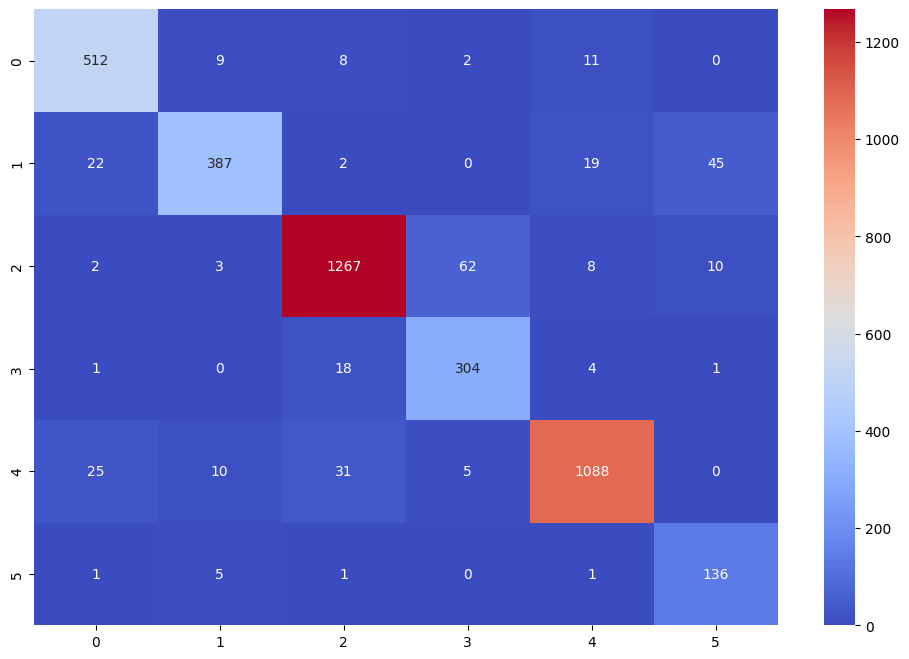

In [39]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (12, 8))

sns.heatmap(confusion_matrix(test_df['Sentiment'], y_predict), fmt = '.0f', annot = True, cmap = 'coolwarm');

In [61]:
test_df['Sentiment'].value_counts()

2    1352
4    1159
0     542
1     475
3     328
5     144
Name: Sentiment, dtype: int64